<h1>Amazon SageMaker와 R을 이용하여 하이퍼파라미터 튜닝하기</h1>

이 샘플 노트북은 Hyperparamter 튜닝을 수행하는 방법과 아래 두 가지 방법을 사용하여 전복 연령에 대한 예측을 생성하는 방법을 보여줍니다.

- [Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) - 트랜스포머를 사용하여 일괄 변환.
- [Deploying the model](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html) - 모델을 엔드포인트로 배포하여 온라인 API로 추론 작업 수행하기. 

이 노트북의 목표는 R에서 어떻게 이러한 방법을 사용할 수 있는지 보여드리는 것입니다.

전복의 나이는 껍질 속의 고리들로 측정합니다. 이 노트북에서는 [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)에서 공개한 [abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone)을 사용할 예정입니다.

여기서는 두 개의 다른 라이브러리를 사용하여 SageMaker와 상호작용합니다:
- [`Reticulate` library](https://rstudio.github.io/reticulate/): R에서 [Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/en/latest/index.html) Amazon SageMaker SDK API 호출을 할 수 있게 하는 인터페이스입니다.  또한 이 `reticulate` 패키지는 R과 Python object들을 변환해 주는 역할을 수행합니다. 그리고 Amazon SageMaker는 대규모 ML 모델을 훈련하고 배포할 수 있는 서버리스 데이터 사이언스 환경을 제공합니다..
- [`paws` library](https://cran.r-project.org/web/packages/paws/index.html): 이 라이브러리는 AWS 서비스에 대한 API 호출을 할 수 있는 인터페이스를 제공합니다. 마치 [`boto3`](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)가 하는 역할과 유사합니다. `boto3` 는 Amazon Web Services (AWS)의 파이썬용 SDK입니다. 파이썬 개발자들은 이 boto3을 이용하여 EC2나 S3와 같은 AWS 서비스들을 생성하고 관리할 수 있습니다. Boto는 사용하기 편하고, 오브젝트 중심의 API로 구성되어 있으며, AWS 서비스의 low level 엑세스도 가능합니다. `paws`는 같은 기능을 R을 이용하여 수행할 수 있도록 해 주는 라이브러리입니다.

목차:
- [R에서 Amazon SageMaker Python SDK 호출 가능한 환경 만들기](#R에서-Amazon-SageMaker-Python-SDK-호출-가능한-환경-만들기)
- [데이터 저장소 생성하고 엑세스하기](#데이터-저장소-생성하고-엑세스하기)
- [데이터셋 다운로드하고 프로세싱하기](#데이터셋-다운로드하고-프로세싱하기)
- [모델 트레이닝을 위해 데이터셋 준비하기](#모델-트레이닝을-위해-데이터셋-준비하기)
- [XGBoost 모델의 하이퍼파라미터 튜닝하기](#XGBoost-모델의-하이퍼파라미터-튜닝하기)
    - [paws 라이브러리로 AWS 서비스를 관리하고 튜닝 작업 상태 확인하기](#paws-라이브러리로-AWS-서비스를-관리하고-튜닝-작업-상태-확인하기)
- [Option 1: Batch Transform](#Option-1:-Batch-Transform)
    - [가장 좋은 트레이닝 작업을 이용하여 모델 만들기](#가장-좋은-트레이닝-작업을-이용하여-모델-만들기)
    - [Tuned Estimator를 이용하여 Batch Transform](#Tuned-Estimator를-이용하여-Batch-Transform)
    - [데이터 다운로드](#데이터-다운로드)
- [Option 2: 엔드포인트를 이용하여 추론하기](#Option-2:-엔드포인트를-이용하여-추론하기)
    - [Tuner 배포하기](#Tuner-배포하기)
    - [배포된 모델로 예측 생성하기](#배포된-모델로-예측-생성하기)
    - [엔드포인트 삭제하기](#엔드포인트-삭제하기)
    
    
**참고:** 이 노트북의 첫 부분은 데이터 입력과 모델 트레이닝을 위한 데이터 준비로 이루어져 있습니다. 이는 ["Using R with Amazon SageMaker"](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/r_kernel/using_r_with_amazon_sagemaker.ipynb) 노트북과 대체로 유사하며, 약간의 차이가 있습니다.
또한 이 노트북의 마지막 부분, 엔드포인트를 이용하여 추론을 생성하는 부분은 다음 노트북에서 설명하는 방법에서 힌트를 얻었습니다: [here](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/r_examples/r_end_2_end/r_sagemaker_abalone.ipynb).

<h3>R에서 Amazon SageMaker Python SDK 호출 가능한 환경 만들기</h3>

먼저, `reticulate` library를 로드하고 `sagemaker` 파이썬 모듈을 import 합니다. 모듈이 로드되고 나면 파이썬에서 `.` 으로 사용하던 클래스 notation을 R의 `$`로 사용할 수 있습니다.

In [1]:
# Turn warnings off globally
options(warn=-1)

In [2]:
# Install reticulate library and import sagemaker
library(reticulate)
sagemaker <- import('sagemaker')

<h3>데이터 저장소를 생성하고 엑세스하기</h3>

이 `Session` 클래스는 Amazon SageMaker에서 다음과 같은 [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) 리소스들을 사용할 수 있는 방법을 제공해 줍니다.

* [S3](https://boto3.readthedocs.io/en/latest/reference/services/s3.html)
* [SageMaker](https://boto3.readthedocs.io/en/latest/reference/services/sagemaker.html)
* [SageMakerRuntime](https://boto3.readthedocs.io/en/latest/reference/services/sagemaker-runtime.html)

데이터를 저장할 [Amazon Simple Storage Service](https://aws.amazon.com/s3/) 버킷을 만들어 봅시다.

In [3]:
session <- sagemaker$Session()
bucket <- session$default_bucket()

**참고** - 이 `default_bucket` 함수는 아래와 같은 형식의 이름으로 새 Amazon S3 버킷을 생성합니다: 

`sagemaker-<aws-region-name>-<aws account number>`

IAM role의 [ARN](https://docs.aws.amazon.com/general/latest/gr/aws-arns-and-namespaces.html) 을 지정하여 Amazon SageMaker가 Amazon S3 버킷에 접근할 수 있도록 해 줍니다. 이 노트북을 생성하는 데 사용된 IAM role을 이용할 수도 있습니다. 

In [4]:
role_arn <- sagemaker$get_execution_role()

<h3>데이터셋 다운로드하고 프로세싱하기</h3>

이 모델은 [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)의 [abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone) 을 사용합니다. 먼저, 데이터를 다운로드하고 [exploratory data analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis)를 수행합니다. tidyverse packages를 이용하여 데이터를 읽고, 시각화하고, Amazon SageMaker로 다루기에 적합한 ML 포맷으로 데이터를 변환합니다.

In [5]:
library(readr)
data_file <- 'http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
abalone <- read_csv(file = data_file, col_names = FALSE)
names(abalone) <- c('sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings')
head(abalone)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double()
)


sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


위의 출력을 보면 factor 데이터 타입에 적합한 `sex`가 현재 character 데이터 타입으로 되어 있는 것을 확인할 수 있습니다. (F는 암컷, M은 수컷, 그리고 I는 새끼입니다) `sex`를 factor 데이터 타입으로 바꾸고 데이터셋의 통계를 살펴보겠습니다:

In [6]:
abalone$sex <- as.factor(abalone$sex)
summary(abalone)

 sex          length         diameter          height        whole_weight   
 F:1307   Min.   :0.075   Min.   :0.0550   Min.   :0.0000   Min.   :0.0020  
 I:1342   1st Qu.:0.450   1st Qu.:0.3500   1st Qu.:0.1150   1st Qu.:0.4415  
 M:1528   Median :0.545   Median :0.4250   Median :0.1400   Median :0.7995  
          Mean   :0.524   Mean   :0.4079   Mean   :0.1395   Mean   :0.8287  
          3rd Qu.:0.615   3rd Qu.:0.4800   3rd Qu.:0.1650   3rd Qu.:1.1530  
          Max.   :0.815   Max.   :0.6500   Max.   :1.1300   Max.   :2.8255  
 shucked_weight   viscera_weight    shell_weight        rings       
 Min.   :0.0010   Min.   :0.0005   Min.   :0.0015   Min.   : 1.000  
 1st Qu.:0.1860   1st Qu.:0.0935   1st Qu.:0.1300   1st Qu.: 8.000  
 Median :0.3360   Median :0.1710   Median :0.2340   Median : 9.000  
 Mean   :0.3594   Mean   :0.1806   Mean   :0.2388   Mean   : 9.934  
 3rd Qu.:0.5020   3rd Qu.:0.2530   3rd Qu.:0.3290   3rd Qu.:11.000  
 Max.   :1.4880   Max.   :0.7600   Max.   :1.00

위의 summary를 보면 `height`의 최소값이 0인 것을 볼 수 있습니다.

각 `sex`의 값에 대해 `rings`와 `height` 간의 관계를 플로팅하여 어떤 전복의 키가 0인지 시각적으로 살펴보겠습니다.

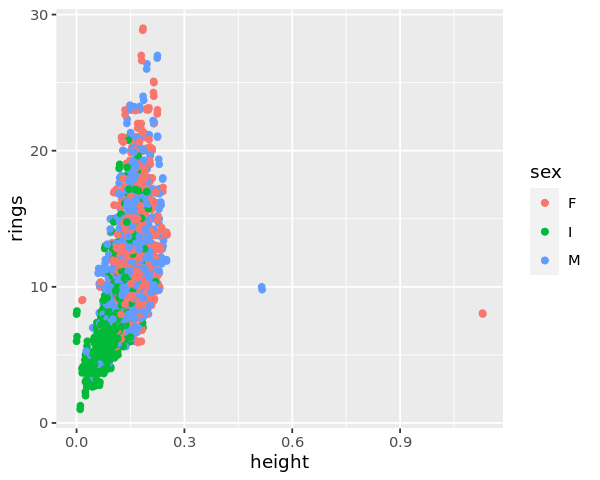

In [7]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height = 4) 
ggplot(abalone, aes(x = height, y = rings, color = sex)) + geom_point() + geom_jitter()

이 플롯에서 여러 개의 outlier들을 볼 수 있습니다. 두 새끼 전복들의 키가 0으로 표시되어 있고, 몇몇 암컷, 수컷 전복들이 다른 전복들보다 훨씬 큰 키로 표시되어 있네요. 키가 0으로 표기된 두 새끼 전복을 필터링해 보겠습니다.

In [8]:
library(dplyr)
abalone <- abalone %>%
  filter(height != 0)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



<h3>모델 트레이닝을 위해 데이터셋 준비하기</h3>

이 모델을 위해서는 세 개의 데이터셋 - 트레이닝용, 테스팅용, 그리고 검증용 - 이 필요합니다. 먼저, `sex`를 [dummy variable](https://en.wikipedia.org/wiki/Dummy_variable_(statistics))로 변경하고 대상인 `rings`를 첫 번째 열로 바꿔줍니다. Amazon SageMaker 알고리즘은 대상이 데이터셋의 첫번째 열에 있어야 합니다.

In [9]:
abalone <- abalone %>%
  mutate(female = as.integer(ifelse(sex == 'F', 1, 0)),
         male = as.integer(ifelse(sex == 'M', 1, 0)),
         infant = as.integer(ifelse(sex == 'I', 1, 0))) %>%
  select(-sex)
abalone <- abalone %>%
  select(rings:infant, length:shell_weight)
head(abalone)

rings,female,male,infant,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15,0,1,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
7,0,1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
9,1,0,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
10,0,1,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
7,0,0,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055
8,0,0,1,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120


다음으로 ML 알고리즘 학습을 위해 데이터의 70 %를 샘플링합니다. 나머지 30 %를 두 개로 나눠 테스트용과 검증용으로 사용하겠습니다:

In [10]:
abalone_train <- abalone %>%
  sample_frac(size = 0.7)
abalone <- anti_join(abalone, abalone_train)
abalone_test <- abalone %>%
  sample_frac(size = 0.5)
abalone_valid <- anti_join(abalone, abalone_test)

Joining, by = c("rings", "female", "male", "infant", "length", "diameter", "height", "whole_weight", "shucked_weight", "viscera_weight", "shell_weight")
Joining, by = c("rings", "female", "male", "infant", "length", "diameter", "height", "whole_weight", "shucked_weight", "viscera_weight", "shell_weight")


이 노트북의 뒷부분에서 일괄 변환(Batch Transform)과 엔드포인트, 이 두 가지 방법으로 추론을 수행한 후 그 결과를 비교해 볼 예정입니다. 한 배치에서 추론을 위해 끝점에 보낼 수 있는 최대 행의 수는 500개입니다. 테스트 데이터 세트의 행 수를 500개로 줄이고, 이를 일괄(batch) 및 온라인 엔드포인트 추론 작업에서 사용하여 비교해 보겠습니다.

In [11]:
num_predict_rows <- 500
abalone_test <- abalone_test[1:num_predict_rows, ]

모델을 트레이닝할 수 있도록 트레이닝 및 검증용 데이터를 Amazon S3에 업로드하겠습니다. 먼저 트레이닝 및 검증용 데이터셋을 .csv 형식으로 로컬 파일 시스템에 저장합니다.

In [12]:
write_csv(abalone_train, 'abalone_train.csv', col_names = FALSE)
write_csv(abalone_valid, 'abalone_valid.csv', col_names = FALSE)

# Remove target from test
write_csv(abalone_test[-1], 'abalone_test.csv', col_names = FALSE)

그 다음, 이 두 개의 데이터셋을 Amazon S3 버킷에 data라는 키 접두사를 붙여 업로드합니다.

In [13]:
s3_train <- session$upload_data(path = 'abalone_train.csv', 
                                bucket = bucket, 
                                key_prefix = 'data')
s3_valid <- session$upload_data(path = 'abalone_valid.csv', 
                                bucket = bucket, 
                                key_prefix = 'data')

s3_test <- session$upload_data(path = 'abalone_test.csv', 
                                bucket = bucket, 
                                key_prefix = 'data')

마지막으로 Amazon SageMaker 알고리즘에 Amazon S3에서의 입력 형식을 정의해 줍니다:

In [14]:
s3_train_input <- sagemaker$s3_input(s3_data = s3_train,
                                     content_type = 'csv')
s3_valid_input <- sagemaker$s3_input(s3_data = s3_valid,
                                     content_type = 'csv')

<h3>XGBoost 모델의 하이퍼파라미터 튜닝하기</h3>

Amazon SageMaker 알고리즘들은 [Docker](https://www.docker.com/) 컨테이너 형태로 사용 가능합니다. [XGBoost](https://en.wikipedia.org/wiki/Xgboost) 모델을 트레이닝하기 위해, AWS 리전 내의 [Amazon Elastic Container Registry](https://aws.amazon.com/ecr/) (Amazon ECR)에 저장되어 있는 트레이닝 컨테이너를 지정하겠습니다.

In [15]:
registry <- sagemaker$amazon$amazon_estimator$registry(session$boto_region_name, algorithm='xgboost')
container <- paste(registry, '/xgboost:latest', sep='')
cat('XGBoost Container Image URL: ', container)

XGBoost Container Image URL:  306986355934.dkr.ecr.ap-northeast-2.amazonaws.com/xgboost:latest

Amazon SageMaker [Estimator](http://sagemaker.readthedocs.io/en/latest/estimators.html)를 정의해 줍니다. 이 Estimator는 Docker로 컨테이너화 되어 있는 알고리즘을 트레이닝하는 데에 사용됩니다. 이 Estimator를 생성할 때에는 아래와 같은 인수들을 사용할 수 있습니다:
* **image_name** - 트레이닝에 사용할 컨테이너 이미지 이름
* **role** - Amazon SageMaker의 서비스 역할
* **train_instance_count** - 트레이닝에 사용할 Amazon EC2 인스턴스들의 갯수
* **train_instance_type** - 트레이닝에 사용할 Amazon EC2 인스턴스의 유형
* **train_volume_size** - 트레이닝하는 동안 입력 데이터를 저장할 [Amazon Elastic Block Store](https://aws.amazon.com/ebs/) (Amazon EBS) 볼륨의 크기(GB)
* **train_max_run** - 최대 트레이닝 시간 (타임아웃)
* **input_mode** - 알고리즘이 지원하는 입력 방식
* **output_path** - 트레이닝 결과(모델 artifact들과 출력 파일들)를 저장할 Amazon S3의 경로
* **output_kms_key** - 트레이닝 결과를 암호화할 [AWS Key Management Service](https://aws.amazon.com/kms/) (AWS KMS)의 키
* **base_job_name** - 트레이닝 작업에 접두사로 붙일 이름
* **sagemaker_session** - Amazon SageMaker API과의 인터렉션을 관리할 세션 오브젝트

In [16]:
s3_output <- paste0('s3://', bucket, '/output')
estimator <- sagemaker$estimator$Estimator(image_name = container,
                                           role = role_arn,
                                           train_instance_count = 1L,
                                           train_instance_type = 'ml.m5.4xlarge',
                                           train_volume_size = 30L,
                                           train_max_run = 3600L,
                                           input_mode = 'File',
                                           output_path = s3_output,
                                           output_kms_key = NULL,
                                           base_job_name = NULL,
                                           sagemaker_session = NULL)

**참고** - R에서의 `NULL`의 경우 파이썬에서는 `None`으로 사용합니다.

다음으로, 이 estimator를 위한 [XGBoost hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html)를 지정하고, [SageMaker Hyperparamter Tuning](https://sagemaker.readthedocs.io/en/stable/tuner.html)에 사용할 하이퍼파라미터의 범위를 지정해 줍니다. [XGBoost 알고리즘에서 튜닝 가능한 하이퍼파라미터의 리스트](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html)를 참조해 주세요. 

그리고 튜닝을 평가할 메트릭을 지정해 주어야 합니다. XGBoost는 아래 아홉 개의 대상 중 하나를 사용할 수 있습니다. 아래의 대상에 대한 세부 정보는  ["Tune an XGBoost Model"](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html) 페이지를 참조해 주세요:

- validation:accuracy
- validation:auc
- validation:error
- validation:f1
- validation:logloss
- validation:mae
- validation:map
- validation:merror
- validation:mlogloss
- validation:mse
- validation:ndcg
- validation:rmse	

이 경우, 회귀 분석 문제이므로 `validation:rmse`를 튜닝 목표로 삼겠습니다.

하이퍼파라미터를 튜닝하기 위해서는 튜닝할 하이퍼파라미터의 범위와 타입을 지정해야 합니다. 문서에 나와 있는 대로, `ContinuousParameter`나 `IntegerParameter`를 선택할 수 있습니다. 그리고 알고리즘 문서에서 하이퍼파라미터 범위의 권고값을 제공하고 있습니다. 

일단 Estimator와 하이퍼파라미터들, 그리고 튜닝 가능한 하이퍼파라미터 범위가 지정되고 나면, `HyperparameterTuner` (tuner)를 만들 수 있습니다. 그리고 튜닝을 수행할 튜너를 트레이닝(또는 피팅)하고 가장 최적화된 모델을 선택할 수 있습니다. 그런 다음 Batch Transform과 함께 이 모델을 사용하거나 모델을 엔드포인트로 배포하고 온라인으로 추론하여 예측을 생성할 수 있습니다.

In [17]:
# Set Hyperparameters
estimator$set_hyperparameters(eval_metric='rmse',
                              objective='reg:linear',
                              num_round=100L,
                              rate_drop=0.3,
                              tweedie_variance_power=1.4)

In [18]:
# Set Hyperparameter Ranges
hyperparameter_ranges = list('eta' = sagemaker$parameter$ContinuousParameter(0,1),
                        'min_child_weight'= sagemaker$parameter$ContinuousParameter(0,10),
                        'alpha'= sagemaker$parameter$ContinuousParameter(0,2),
                        'max_depth'= sagemaker$parameter$IntegerParameter(0L,10L))

In [19]:
# Set the tuning objective to RMSE
objective_metric_name = 'validation:rmse'

`HyperparameterTuner` 에는 여러 개의 파라미터를 지정할 수 있습니다. 이 파라미터들의 간단한 리스트는 아래와 같습니다. 전체 리스트 및 세부 내용을 확인하고 싶으신 경우 다음 링크를 참조해 주세요: [`HyperparameterTuner` Documentation](https://sagemaker.readthedocs.io/en/stable/tuner.html#hyperparametertuner) :

- **estimator** (sagemaker.estimator.EstimatorBase) – 지정한 설정으로 초기화된 Estimator 객체. 이 인스턴스와 트레이닝 작업이 연관될 필요는 없음.
- **objective_metric_name** (str) – 트레이닝 작업을 평가하기 위한 목표 메트릭 이름.
- **hyperparameter_ranges** (dict[str, sagemaker.parameter.ParameterRange]) – 딕셔너리 형태의 파라미터 범위. 이 파라미터 범위들은 다음 세 가지 타입 중 하나가 될 수 있음: Continuous, Integer, or Categorical. 
- **objective_type** (str) – 트레이닝 작업을 평가하기 위한 목표 메트릭의 타입. 이 값은 ‘Minimize’ 또는 ‘Maximize’가 될 수 있음(기본값: ‘Maximize’).
- **max_jobs** (int) – 하이퍼파라미터 튜닝 작업을 수행할 최대 트레이닝 작업의 수 (기본값: 1).
- **max_parallel_jobs** (int) – 병렬 수행할 트레이닝 작업의 최대 개수 (default: 1).

In [20]:
# Create a hyperparamter tuner
tuner <- sagemaker$tuner$HyperparameterTuner(estimator,
                                             objective_metric_name,
                                             hyperparameter_ranges,
                                             objective_type='Minimize',
                                             max_jobs=10L,
                                             max_parallel_jobs=4L)

In [21]:
# Create a tuning job name
job_name <- paste('sagemaker-tune-xgboost', format(Sys.time(), '%H-%M-%S'), sep = '-')

# Define the data channels for train and validation datasets
input_data <- list('train' = s3_train_input,
                   'validation' = s3_valid_input)

# train the tuner
tuner$fit(inputs = input_data, job_name = job_name, include_cls_metadata=FALSE)


#### `paws` 라이브러리로 AWS 서비스를 관리하고 튜닝 작업 상태 확인하기

AWS 서비스에 대한 API 호출을 할 수 있는 인터페이스를 제공합니다. 마치 [`boto3`](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)가 하는 역할과 유사합니다. `boto3` 는 Amazon Web Services (AWS)의 파이썬용 SDK입니다.

[`paws` package](https://cran.r-project.org/web/packages/paws/index.html) 는 스토리지나 데이터베이스, 컴퓨트 서비스와 같은 AWS 리소스를 관리할 수 있는 Amazon Web Services (AWS) Software Development Kit (SDK)입니다. 파이썬 `boto3`의 R 버전이라고 보시면 됩니다.

튜닝 작업을 수행하는 데 시간이 조금 걸릴 겁니다. 우리는 이 `paws`의 `sagemaker$describe_hyper_parameter_tuning_job`을 이용하여 SageMaker에서 튜닝 작업의 현재 상태를 확인해 볼 겁니다. `paws`를 `reticulate`과 함께 사용하면 R을 이용하여 쉽게 AWS 서비스들을 관리할 수 있습니다. [세부적인 내용은 여기서 찾아보실 수 있습니다](https://cran.r-project.org/web/packages/paws/paws.pdf).

In [22]:
# Install paws package
install.packages('paws')
library(paws)

also installing the dependencies ‘ini’, ‘paws.common’, ‘paws.compute’, ‘paws.storage’, ‘paws.database’, ‘paws.networking’, ‘paws.management’, ‘paws.machine.learning’, ‘paws.analytics’, ‘paws.security.identity’, ‘paws.application.integration’, ‘paws.cost.management’, ‘paws.customer.engagement’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [23]:
# Create a paws SageMaker session
sm <- paws::sagemaker()

In [24]:
# Get the status of the tuning job
status <- sm$describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner$latest_tuning_job$job_name)

cat('Hyperparameter Tuning Job Name: ', job_name,'\n')
cat('Hyperparameter Tuning Job Status: ', status$HyperParameterTuningJobStatus,'\n')
cat('Succeeded Models:', status$ObjectiveStatusCounters$Succeeded,'\n')
cat('InProgress Modles:', status$ObjectiveStatusCounters$Pending,'\n')
cat('Failed Modles:', status$ObjectiveStatusCounters$Failed,'\n')


Hyperparameter Tuning Job Name:  sagemaker-tune-xgboost-01-16-51 
Hyperparameter Tuning Job Status:  InProgress 
Succeeded Models: 4 
InProgress Modles: 4 
Failed Modles: 0 


In [25]:
# Print best training hyperparamters
status$BestTrainingJob$TunedHyperParameters

$alpha
[1] "0.8166041326507338"

$eta
[1] "0.4410178804793323"

$max_depth
[1] "10"

$min_child_weight
[1] "4.0592985895930696"

In [26]:
# Print Evaluation Metric
status$BestTrainingJob$FinalHyperParameterTuningJobObjectiveMetric

$Type
character(0)

$MetricName
[1] "validation:rmse"

$Value
[1] 2.41004

In [27]:
# Name of the best training job model
status$BestTrainingJob$TrainingJobName

[1] "sagemaker-tune-xgboost-01-16-51-001-3a99faa7"

<hr>

## Option 1: Batch Transform

### 가장 좋은 트레이닝 작업을 이용하여 모델 만들기
여기서는 하이퍼파리미터 최적화 작업을 통해 얻은 가장 좋은 트레이닝 작업 결과와, S3에 저장된 모델 artifact를 사용하여 어떻게 모델을 생성할 수 있는지 살펴보겠습니다. 그리고 는 방법을 살펴보겠습니다.

먼저 모델 컨테이너를 생성해야 합니다. 아래와 같은 파라미터가 필요합니다:
- **Image:** 알고리즘 컨테이너의 URL 
- **ModelDataUrl:** 하이퍼파라미터 트레이닝 작업의 결과로 S3에 저장된 모델 tarball(model.tar.gz)의 위치

`paws` 라이브러리와 `describe_training_job()` 메소드를 이용하여 가장 좋은 트레이닝 작업을 표시하고, **ModelDataUrl**을 가져올 수 있습니다.[세부 정보는 여기 참조](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.describe_training_job).
 
그리고 이 모델 컨테이너를 이용하여 모델을 생성할 겁니다. `paws` 라이브러리와 `create_model` 메소드를 사용합니다. [이 메소드에 대한 세부 정보는 여기 참조](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_model). 

In [28]:
# Describe best training model from hypertuning to get the location of the model artifact on S3
model_artifact <- sm$describe_training_job(
    TrainingJobName = status$BestTrainingJob$TrainingJobName
)$ModelArtifacts$S3ModelArtifacts

model_artifact

[1] "s3://sagemaker-ap-northeast-2-005481306090/output/sagemaker-tune-xgboost-01-16-51-001-3a99faa7/output/model.tar.gz"

In [29]:
# Create a model container
model_container <- list(
    "Image"= container,
    "ModelDataUrl" = model_artifact
    )

In [30]:
# Create a model

model_name <- paste('sagemaker-model-xgboost', format(Sys.time(), '%H-%M-%S'), sep = '-')

best_model <- sm$create_model(
    ModelName = model_name,
    PrimaryContainer = model_container,
    ExecutionRoleArn = role_arn
)

### Tuned Estimator를 이용하여 Batch Transform

SageMaker Batch Transform에 대해 더 자세히 알고 싶으신 경우, 이 노트북을 참조해 주세요: [Amazon SageMaker Batch Transform](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker_batch_transform/introduction_to_batch_transform/batch_transform_pca_dbscan_movie_clusters.ipynb).

추론을 위해 온라인 모델을 배포하여 사용하는 것은 어떤 상황에서는 가장 좋은 옵션이 아닐 수 있습니다. 특히나 온라인 실시간 추론이 필요하지 않은 경우, 잘 훈련된 모델에 거대한 데이터셋을 사용하여 예측을 생성해야 하는 경우가 그렇죠. 이런 경우에는 Batch Transform을 사용하는 것이 보다 효과적이고 적합합니다.

여기서는 어떻게 Batch Transform 작업을 설정하고 예측을 생성하는지 알아보겠습니다.

이를 위해서 먼저 S3의 batch 입력 데이터 경로를 지정해 주어야 합니다. 그리고 생성된 예측을 어디에 저장할지도 설정해야 합니다.

In [31]:
# Define S3 path for Test data and output path

s3_test_url <- paste('s3:/',bucket,'data','abalone_test.csv', sep = '/')
output_path <- paste('s3:/',bucket,'output/batch_transform_output',job_name, sep = '/')

이제 `Transformer`를 생성합니다. [Transformers](https://sagemaker.readthedocs.io/en/stable/transformer.html#transformer) 는 아래와 같이 여러 개의 파라미터를 받을 수 있습니다. 세부 내용은 다음 링크를 참조하세요: [documentation page](https://sagemaker.readthedocs.io/en/stable/transformer.html#transformer).

- **model_name** (str) – 변환 작업에 사용할 SageMaker 모델의 이름.
- **instance_count** (int) – 사용할 EC2 인스턴스들의 개수.
- **instance_type** (str) – 사용할 EC2 인스턴스의 타입. 예를 들어, ‘ml.c4.xlarge’.

- **output_path** (str) – 변환 결과를 저장할 S3 위치. 지정되지 않을 경우 기본 버킷에 저장됨.

- **base_transform_job_name** (str) – transform() 메소드가 수행될 때 변환 작업 이름 앞에 붙을 접두사. 만약 지정하지 않은 경우 변환 작업과 연관된 트레이닝 이미지 이름에 따라서 기본 접두사가 생성됩니다. 

- **sagemaker_session** (sagemaker.session.Session) – Amazon SageMaker API 및 필요한 기타 AWS 서비스와의 상호 작용을 관리하는 세션 객체. 지정되지 않은 경우 estimator가 기본 AWS 구성 체인을 사용하여 생성합니다.

`Transformer`를 만들고 나면 이제 배치 입력을 변환할 수 있습니다.

In [32]:
# Instantiate a SageMaker transformer
transformer <- sagemaker$transformer$Transformer(
    model_name = model_name,
    instance_count=1L,
    instance_type='ml.m5.4xlarge',
    output_path=output_path,
    base_transform_job_name='R-Transformer',
    sagemaker_session=session)

In [33]:
# Tranform the test data and wait until the task completes
transformer$transform(s3_test_url)
transformer$wait()

In [34]:
# Get the status of Batch Transform
sm$describe_transform_job(TransformJobName = transformer$latest_transform_job$job_name)$TransformJobStatus


[1] "Completed"

### 데이터 다운로드

In [35]:
sagemaker$s3$S3Downloader$download(paste(output_path,"abalone_test.csv.out",sep = '/'),
                          "batch_output")

In [36]:
# Read the batch csv from sagemaker local files
library(readr)
predictions <- read_csv(file = 'batch_output/abalone_test.csv.out', col_names = 'predicted_rings')
head(predictions)

Parsed with column specification:
cols(
  predicted_rings = col_double()
)


predicted_rings
<dbl>
8.920068
7.574365
7.325480
11.680574
10.927720
5.412214


테스트 데이터에 예측한 고리 수 열을 바인드합니다:

In [37]:
# Concatenate predictions and test for comparison
abalone_predictions <- cbind(predicted_rings = predictions, 
                      abalone_test)
# Convert predictions to Integer
abalone_predictions$predicted_rings = as.integer(abalone_predictions$predicted_rings);
head(abalone_predictions)

,predicted_rings,rings,female,male,infant,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8,10,0,1,0,0.470,0.360,0.135,0.5010,0.1665,0.1150,0.165
2,7,6,0,0,1,0.370,0.275,0.085,0.2045,0.0960,0.0560,0.080
3,7,8,0,0,1,0.435,0.340,0.120,0.3960,0.1775,0.0810,0.125
4,11,7,0,0,1,0.505,0.390,0.185,0.6125,0.2670,0.1420,0.172
5,10,11,0,1,0,0.570,0.455,0.155,0.8320,0.3585,0.1740,0.277
6,5,8,0,0,1,0.300,0.230,0.080,0.1275,0.0435,0.0265,0.040


In [38]:
# Define a function to calculate RMSE
rmse <- function(m, o){
  sqrt(mean((m - o)^2))
}

In [39]:
# Calucalte RMSE
abalone_rmse <- rmse(abalone_predictions$rings, abalone_predictions$predicted_rings)
cat('RMSE for Batch Transform: ', round(abalone_rmse, digits = 2))

RMSE for Batch Transform:  2.36

<hr>

## Option 2: 엔드포인트를 이용하여 추론하기
<h3>Tuner 배포하기</h3>

여기서는 튜닝된/트레이닝된 모델을 배포하는 프로세스를 설명합니다. 그리고 엔드포인트로 배포된 모델을 이용하여 테스트 데이터에 대해 예측을 수행할 겁니다. 엔드포인트로 모델을 배포하는 것은 온라인 추론이 필요한 경우 적합합니다. 배치 데이터를 이용하여 예측을 하는 경우, 앞서 살펴본 Batch Transform을 사용하는 것이 좋습니다.

Amazon SageMaker를 이용하면 쉽고 간단하게 모델을 배포하여([deploy your model](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html)), 사용자들이 HTTPS request를 보낼 수 있는 API 엔드포인트를 제공할 수 있습니다. 우리가 방금 트레이닝시킨 모델을 `ml.t2.medium` 인스턴스에 배포해 보겠습니다. 이 작업은 몇 분 정도 소요됩니다.

In [ ]:
model_endpoint <- tuner$deploy(initial_instance_count = 1L,
                                   instance_type = 'ml.t2.medium')

<h3>배포된 모델로 예측 생성하기</h3>

테스트 데이터를 사용하여 예측을 만들어 보겠습니다. 엔드포인트 설정에 `text/csv` 와 `csv_serializer`를 지정해서 콤마로 구분된(comma-separated) csv 텍스트를 JSON 포맷으로 직렬화하여 넘겨줍니다.

In [ ]:
model_endpoint$content_type <- 'text/csv'
model_endpoint$serializer <- sagemaker$predictor$csv_serializer

대상 열(column)을 지우고 처음 500개의 관찰(행)들을 열의 이름이 없는 매트릭스로 변환합니다.

In [ ]:
test_sample <- as.matrix(abalone_test[-1])
dimnames(test_sample)[[2]] <- NULL

**참고** - 관찰 행의 수를 500으로 설정한 이유는 엔드포인트의 제한을 넘기지 않기 위해서입니다.

엔드포인트로부터 예측을 생성하고, 결과로 나온 콤마로 구분된(comma-separated) 문자열을 변환해 보겠습니다.

In [ ]:
library(stringr)
predictions_ep <- model_endpoint$predict(test_sample)
predictions_ep <- str_split(predictions_ep, pattern = ',', simplify = TRUE)
predictions_ep <- as.integer(unlist(predictions_ep))

예측한 고리의 수가 기록된 열을 테스트 데이터에 바인드합니다.

In [ ]:
# Convert predictions to Integer
abalone_predictions_ep <- cbind(predicted_rings = predictions_ep, 
                      abalone_test)
# abalone_predictions = as.integer(abalone_predictions)
head(abalone_predictions_ep)

In [ ]:
# Calucalte RMSE
abalone_rmse_ep <- rmse(abalone_predictions_ep$rings, abalone_predictions_ep$predicted_rings)
cat('RMSE for Endpoint 500-Row Prediction: ', round(abalone_rmse_ep, digits = 2))

<h3>엔드포인트 삭제하기</h3>

모델을 모두 사용했다면, 엔드포인트를 삭제하여 비용이 낭비되지 않도록 합니다.

In [ ]:
session$delete_endpoint(model_endpoint$endpoint)